In [66]:
%matplotlib notebook
import datetime
import obspy

import matplotlib
import numpy 
import warnings
warnings.filterwarnings('ignore')

from math import radians, cos, sin, asin, sqrt

def plot_Mfirst(self=obspy.core.event.catalog.Catalog()):
    mags =          [e.magnitudes[-1].mag                        for e in self.events ]
    profs =         [e.origins[-1].depth/1000.                   for e in self.events ]
    mags_stations = [e.magnitudes[-1].station_count              for e in self.events ]
    m1_errors =     [e.magnitudes[-1].mag-e.magnitudes[0].mag    for e in self.events ]
    m1_types =      [e.magnitudes[0].magnitude_type              for e in self.events ]
    m1_times =      [e.magnitudes[0].creation_info.creation_time for e in self.events ]
    m1_origint =    [e.origins[-1].time                          for e in self.events ]
    m1_delays = numpy.asarray(m1_times)-numpy.asarray(m1_origint)
    
    if len(mags) >0:
        f, (ax) = matplotlib.pyplot.subplots(1, 1)
        matplotlib.pyplot.ylabel('Error in first M')
        matplotlib.pyplot.xlabel('Reference M')
        matplotlib.pyplot.title('First M, with delays')
        matplotlib.pyplot.grid()

        for m in [min(mags_stations),numpy.median(mags_stations),max(mags_stations)]:
            sc = ax.scatter(numpy.mean(mags), 0, 
                            (m-min(mags_stations)+1)/(max(mags_stations)-min(mags_stations))*500, 
                            'w', 'o', label=str(int(m))+' stat.',alpha=0.7 )

        ax.axhline(0, linestyle='--', color='k') # horizontal lines

        if len(m1_delays)<64:
            for i, txt in enumerate(m1_delays):
                ax.text(mags[i], m1_errors[i], str(int(txt))+'s', weight="heavy",
                        color="k", zorder=100,
                        path_effects=[
                            matplotlib.patheffects.withStroke(linewidth=3,
                                                   foreground="white")])
        types = ['M*','MLv','MVS']
        for i,m in enumerate(['+','^','o']):
            matches = [ j for j,t in enumerate(m1_types) if t == types[i] ]
            if matches:
                sc = ax.scatter([mags[j] for j in matches] , 
                                [m1_errors[j] for j in matches] , 
                                [(mags_stations[j]-min(mags_stations)+1)/(max(mags_stations)-min(mags_stations))*500 for j in matches] ,
                                [profs[j] for j in matches], 
                                m, 
                                norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=numpy.max(profs)),
                                label=types[i],alpha=0.5,zorder=150,edgecolors='k')
        cb=matplotlib.pyplot.colorbar(sc)
        cb.set_label('Reference depth (km)')
        lg = matplotlib.pyplot.legend()
        lg.set_title('Marker & Sizes')
        lg.get_frame().set_alpha(0.1)
        lg.get_frame().set_color('k')
        matplotlib.pyplot.axis('equal')
        print(self)

def plot_eew(self=obspy.core.event.catalog.Catalog()):
    mags =          [e.magnitudes[-1].mag                        for e in self.events ]
    profs =         [e.origins[-1].depth/1000.                   for e in self.events ]
    mags_stations = [e.magnitudes[-1].station_count              for e in self.events ]
    m1_errors =     [e.magnitudes[-1].mag-e.magnitudes[0].mag    for e in self.events ]
    m1_types =      [e.magnitudes[0].magnitude_type              for e in self.events ]
    m1_times =      [e.magnitudes[0].creation_info.creation_time for e in self.events ]
    m1_origint =    [e.origins[-1].time                          for e in self.events ]
    m1_delays = numpy.asarray(m1_times)-numpy.asarray(m1_origint)
    
    if len(mags) >0:
        f, (ax1,ax2) = matplotlib.pyplot.subplots(2, 1, sharex=True)
        ax1.set_ylabel('Error in location (km)')
        ax2.set_ylabel('Error in magnitude')
        ax1.set_xlabel('Time after origins (s)')
        ax2.set_xlabel('Time after origins (s)')
        ax2.set_xscale('log')
        ax1.set_xscale('log')
        #x1.set_yscale('log')
        ax1.xaxis.set_label_position('top') 
        ax1.xaxis.set_ticks_position('top') 
        ax1.grid()
        ax2.grid()


        dmins=[]
        for e in self.events:
            for o in e.origins:
                if len(o.arrivals)>0:
                    dmins.append(numpy.min([a.distance for a in o.arrivals]))


        for e in self.events:

            el =  [numpy.sqrt(haversine(e.origins[-1].longitude,e.origins[-1].latitude,o.longitude,o.latitude)**2+(e.origins[-1].depth-o.depth)**2)/1000 for o in e.origins]
            dtl = [o.creation_info.creation_time-e.origins[-1].time for o in e.origins]   

            picks = e.picks.copy()
            for i,o in enumerate(e.origins):
                picks_creationtime = []
                picks_time = []
                picks_el = []
                plist = []
                if i<len(e.origins):
                    for a in o.arrivals:                 
                        if a.time_weight < 4 : #abs(a.time_residual)<(a.distance)/5./3:
                            for p in picks:
                                if a.pick_id == p.resource_id and p.time-e.origins[-1].time > .5 and p.time not in plist:
                                    picks_time.append(p.time-e.origins[-1].time)
                                    picks_creationtime.append(p.creation_info.creation_time-e.origins[-1].time)
                                    picks_el.append(el[i])
                                    picks.remove(p)
                                    plist.append(p.time)
                                    break

                    ax1.scatter(picks_time,picks_el,10,
                                numpy.repeat(e.magnitudes[-1].mag,len(picks_el)),#marker='+',
                                norm=matplotlib.colors.PowerNorm(1,vmin=0.01, vmax=numpy.max(mags)),
                                zorder=-99,alpha=0.3, edgecolors='none')


            ax1.scatter(dtl[:-1],el[:-1],10,marker='o',edgecolors='k') 
            sc1 = ax1.scatter(dtl[:-1],el[:-1],10,
                        numpy.repeat(e.magnitudes[-1].mag,len(dtl)-1),marker='o',
                        norm=matplotlib.colors.PowerNorm(1,vmin=0.01, vmax=numpy.max(mags)),
                        label=e.short_str(),linewidths=0,zorder=999)


            em =  [e.magnitudes[-1].mag-m.mag           for m in e.magnitudes]
            dtm = [m.creation_info.creation_time-e.origins[-1].time for m in e.magnitudes]

            ax2.scatter(dtm[:-1],em[:-1],10,marker='o',edgecolors='k')      
            sc2 = ax2.scatter(dtm[:-1],em[:-1],10,
                        numpy.repeat(e.magnitudes[-1].mag,len(dtm)-1),marker='o',
                        norm=matplotlib.colors.PowerNorm(1,vmin=0.01, vmax=numpy.max(mags)),
                        label=e.short_str(),linewidths=0,zorder=999)  

        cb=matplotlib.pyplot.colorbar(sc1, ax=[ax1,ax2])
        cb.set_label('Reference magnitude')
        ob2 = ax2.scatter(20,0,10,marker='o',alpha=0.1,color='b', edgecolors='none',zorder=-999)
        ob1 = ax2.scatter(20,0,10,marker='o',color='b',edgecolors='k',zorder=-999)
        ax2.scatter(20,0,10,marker='o',color='w',edgecolors='w',linewidths=3,zorder=-99)
        lg = matplotlib.pyplot.legend((ob1, ob2), ('Solutions (loc. or M)', 'Picks (t or A)'))

def evfind(self=obspy.core.event.catalog.Catalog(),tofind=obspy.core.event.catalog.Catalog(),v=False):
    
    matchs = obspy.core.event.catalog.Catalog()
    matchs.description = 'Intersections of '+str(self.description)+' and '+str(tofind.description)
    missed = obspy.core.event.catalog.Catalog()
    missed.description = 'Part of '+str(self.description)+' not in '+str(tofind.description)
    
    for e in tofind.events:
        o = e.preferred_origin() or e.origins[-1]
        found=False     
        if v:
            print('---- event',e.short_str(),'...')
        for ref in self.events: 
            refo = ref.preferred_origin() or ref.origins[-1]
            if abs(o.time-refo.time) < 60 and abs(o.latitude-refo.latitude)<=.5 and abs(o.longitude-refo.longitude)<=.5: 
                found=True  
                if v:
                    print('fits input catalog ',tofind.description,':\n  ', ref.short_str())                
                matchs.events.append(ref)
            
            elif abs(o.time-refo.time) < 60 and abs(o.latitude-refo.latitude)<1 and abs(o.longitude-refo.longitude)<1: 
                found=True  
                if v:
                    print('poorly fits input catalog ',tofind.description,':\n  ', ref.short_str())                
                matchs.events.append(ref)
                
        if not found:
            if v:
                print('does not exist in current catalog')            
            missed.events.append(e)
            
    return matchs, missed

def hasdata(self,data=obspy.core.stream.Stream()):
    inv_ok = obspy.core.inventory.Inventory(networks=[],source=[])
    l = []
    for t in data.traces:
        if t.stats.network+t.stats.station not in l:
            toadd = inv.select(network=t.stats.network,station=t.stats.station)
            if len(toadd.networks) >0:
                found = False
                for n in inv_ok.networks:
                    if n.code == t.stats.network:
                        n.stations.append(toadd.networks[0].stations[0])
                        found = True
                if not found:
                    inv_ok.__iadd__(toadd)
                l.append(t.stats.network+t.stats.station)
    return inv_ok

obspy.core.inventory.Inventory.hasdata = hasdata
obspy.core.event.catalog.Catalog.evfind = evfind
obspy.core.event.catalog.Catalog.plot_Mfirst = plot_Mfirst
obspy.core.event.catalog.Catalog.plot_eew = plot_eew

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371000 # Radius of earth in meters. Use 3956 for miles
    return c * r 

from obspy.clients.fdsn import Client
client_eew = Client('http://localhost:18080')
client_eq = Client('http://165.98.224.52:8081')
#client_wf = Client('http://165.98.224.59:8081')
client = Client('USGS')

N=7
minM = 4.9
lon=[-95,-80]
lat=[10,15]
net='NU'
end = (datetime.datetime.now()).isoformat()
start = (datetime.datetime.now()-datetime.timedelta(days=N)).isoformat()
endsample = (datetime.datetime.now()-datetime.timedelta(days=N)+datetime.timedelta(seconds=1)).isoformat()

# ssh -N -L 18080:localhost:8080  sysop@165.98.224.44

# Review of the earthquake early warning system for the N days. 

In [13]:
print('N: %s' % str(N))
print('into area %s°N %s°E' % (str(lat), str(lon)))
print("from %s" % start )
print("  to %s" % end )
print('for network %s.' % net)

N: 3
into area [10, 15]°N [-95, -80]°E
from 2017-02-24T16:35:17.283536
  to 2017-02-27T16:35:17.283467
for network NU.


## INETER observations
### Available network

<IPython.core.display.Javascript object>


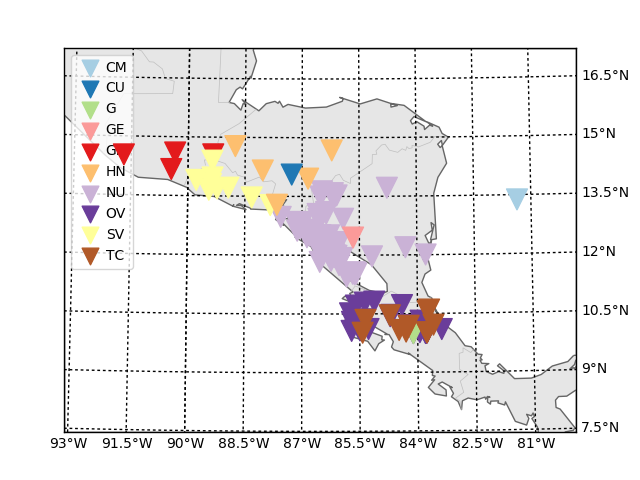

Inventory created at 2017-02-27T16:57:38.000000Z
	Sending institution: SeisComP3 (INETER)
	Contains:
		Networks (1):
			NU
		Stations (103):
			NU.AAHN (Alcaldia de Achuapa)
			NU.ABCN (SMA Banco Central, Nicaragua)
			NU.ACBN (SMA Campo Bello, Nicaragua)
			NU.ACON (Acoyapa, Nicaragua)
			NU.ACSN (SMA Ciudad Sandino, Nicaragua)
			NU.ADRN (SMA Diriamba, Nicaragua)
			NU.AERN (SMA Aeropuerto Managua, Nicaragua)
			NU.AESN (EL SAUCE LEON)
			NU.ALEN (SMA Leon, Nicaragua)
			NU.ALLN (SMA Telcor Managua, Nicaragua)
			NU.ALTN (Altagracia, Isla de ometepe)
			NU.AMTN (SMA Mateare, Nicaragua)
			NU.AMYN (SMA CODE Masaya, Nicaragua)
			NU.APQ2 (Apoyeque, Nicaragua)
			NU.APQ3 (Volcan Apoyeque sitio 3, Nicaragua)
			NU.APQ4 (Volcan Apoyeque sitio 4, Nicaragua)
			NU.APQ5 (Volcan Apoyeque sitio 5, Nicaragua)
			NU.APQN (BB Volcan Apoyeque, Nicaragua)
			NU.APYN (Volcan Apoyeque)
			NU.ARIN (SMA Rivas, Nicaragua)
			NU.AZCN (Norte del Volcan Masaya)
			NU.BC84 (SMA Volcan Momotombo, Nicaragua)


In [61]:
inventory = client_eq.get_stations(starttime=start,endtime=end,minlatitude=lat[0],
                             maxlatitude=lat[1],minlongitude=lon[0],maxlongitude=lon[1],
                             level='station')
fig = inventory.plot(projection='local',color_per_network=True)
print(inventory.select(network='NU'))

###  Network that actually worked

<IPython.core.display.Javascript object>


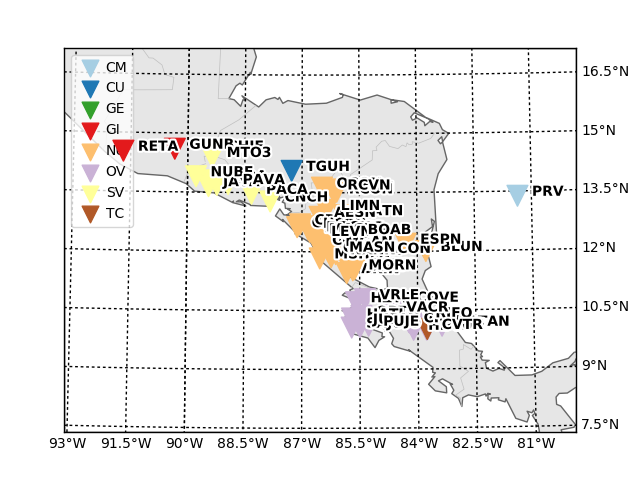

Inventory created at 2017-02-27T16:57:58.913722Z
	Created by: ObsPy 1.0.2
		    https://www.obspy.org
	Sending institution: SeisComP3 (INETER)
	Contains:
		Networks (1):
			NU
		Stations (55):
			NU.ABCN (SMA Banco Central, Nicaragua)
			NU.ACON (Acoyapa, Nicaragua)
			NU.ADRN (SMA Diriamba, Nicaragua)
			NU.AERN (SMA Aeropuerto Managua, Nicaragua)
			NU.AESN (EL SAUCE LEON)
			NU.ALLN (SMA Telcor Managua, Nicaragua)
			NU.AMTN (SMA Mateare, Nicaragua)
			NU.AMYN (SMA CODE Masaya, Nicaragua)
			NU.APQ2 (Apoyeque, Nicaragua)
			NU.ARIN (SMA Rivas, Nicaragua)
			NU.BC84 (SMA Volcan Momotombo, Nicaragua)
			NU.BC87 (SMA San Francisco Libre, Nicaragua)
			NU.BC8A (SMA INETER, Nicaragua)
			NU.BLUN (Bluefields, Entresa, Nicaragua)
			NU.CHNN (SMA Chinadega, Nnicaragua)
			NU.CNGA (Al SSO del Volcan Cerro Negro)
			NU.CNGN (Volcan Cerro Negro, Nicaragua)
			NU.CONN (Central Sismica - INETER)
			NU.COPN (Copaltepe)
			NU.CRIN (volcan San Cristobal, Nicaragua)
			NU.CRUN (El Crucero)
			NU.DEC

In [62]:
test_data = client_eq.get_waveforms('*','*','*','*Z',start,endsample)
inventory_ok = inventory.hasdata(test_data)
inventory_ok.plot(projection='local',color_per_network=True)
print(inventory_ok.select(network='NU'))

### Observed earthquakes
In main earthquake authoritative location system, say **EAL**.

<IPython.core.display.Javascript object>


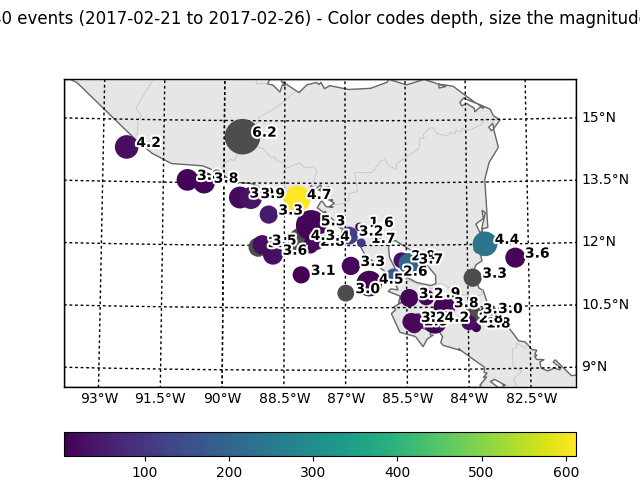

40 Event(s) in Catalog:
2017-02-23T11:27:27.298881Z | +12.447,  -86.651 | 1.638089285 M  | manual
2017-02-23T06:56:31.334140Z | +12.063,  -86.607 | 1.681117139 M  | manual
...
2017-02-24T13:41:11.509563Z | +12.487,  -87.841 | 5.328495115 M  | manual
2017-02-21T07:15:14.338108Z | +14.613,  -89.548 | 6.184471105 M  | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [67]:
cat = client_eq.get_events(starttime=start,endtime=end,#  
                           minlatitude=lat[0],maxlatitude=lat[1],
                           minlongitude=lon[0],maxlongitude=lon[1],
                           orderby='magnitude-asc')
fig = cat.plot(projection='local')
print(cat)

### The most important earthquakes

<IPython.core.display.Javascript object>


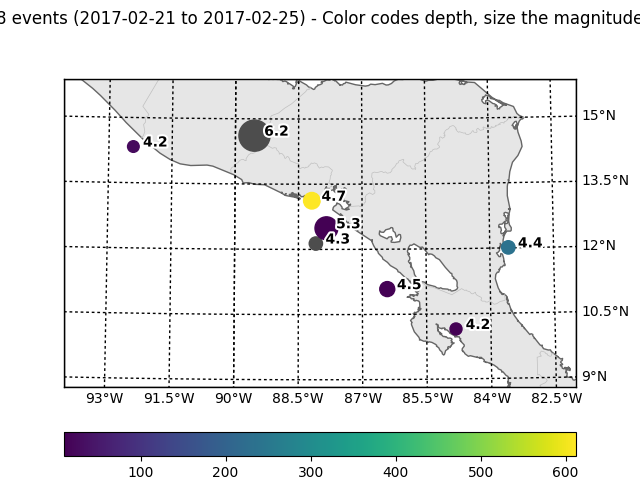

8 Event(s) in Catalog:
2017-02-25T12:44:17.532606Z | +14.332,  -92.421 | 4.170326462 M  | manual
2017-02-25T22:32:42.707170Z | +10.151,  -84.816 | 4.209301951 M  | automatic
2017-02-23T15:16:13.826359Z | +12.135,  -88.090 | 4.341876319 M  | manual
2017-02-24T18:14:25.645934Z | +12.011,  -83.564 | 4.35089902 M  | automatic
2017-02-22T22:10:52.931751Z | +11.083,  -86.416 | 4.519285499 M  | automatic
2017-02-24T11:49:22.402122Z | +13.120,  -88.185 | 4.675778741 M  | automatic
2017-02-24T13:41:11.509563Z | +12.487,  -87.841 | 5.328495115 M  | manual
2017-02-21T07:15:14.338108Z | +14.613,  -89.548 | 6.184471105 M  | manual


In [68]:
subcat = cat.filter("magnitude >= 4.0")
fig = subcat.plot(projection='local',resolution='i')
print(subcat)

## Global observations

<IPython.core.display.Javascript object>


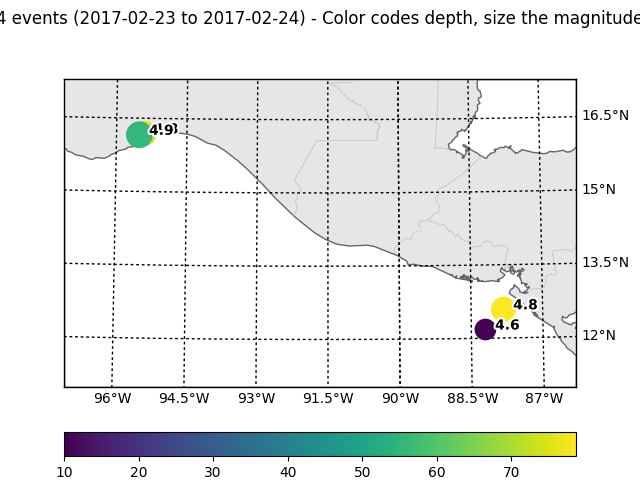

4 Event(s) in Catalog:
2017-02-23T15:16:11.900000Z | +12.179,  -88.206 | 4.6 mb
2017-02-23T09:47:55.710000Z | +16.189,  -95.414 | 4.8 mb
2017-02-24T13:41:14.960000Z | +12.587,  -87.821 | 4.8 mb
2017-02-23T15:21:14.830000Z | +16.160,  -95.513 | 4.9 mb


In [69]:
client = Client('IRIS')
cat_glob = obspy.core.event.catalog.Catalog()
try:
    cat_glob = client.get_events(starttime=start,endtime=end,
                                 minlatitude=lat[0]-1,maxlatitude=lat[1]+2,
                                 minlongitude=lon[0]-1,maxlongitude=lon[1]+2,
                                 orderby='magnitude-asc')
except:
    pass
if len(cat_glob)>0:
    cat_glob.description='IRIS'
    fig = cat_glob.plot(projection='local',resolution='i')
print(cat_glob)

### Is something missing in EAL?

In [70]:
matchs, missed = cat.evfind(cat_glob)
print(missed)

2 Event(s) in Catalog:
2017-02-23T09:47:55.710000Z | +16.189,  -95.414 | 4.8 mb
2017-02-23T15:21:14.830000Z | +16.160,  -95.513 | 4.9 mb


###  Review of missing earthquakes

In [71]:
['scolv -E '+str(e.resource_id) for e in missed ] 

['scolv -E smi:service.iris.edu/fdsnws/event/1/query?eventid=10003253',
 'scolv -E smi:service.iris.edu/fdsnws/event/1/query?eventid=10003349']

### Is there extra in EAL?

In [72]:
matchs, extras = cat_glob.evfind( cat.filter("magnitude >= 5.0") )
print(extras)

1 Event(s) in Catalog:
2017-02-21T07:15:14.338108Z | +14.613,  -89.548 | 6.184471105 M  | manual


###  Review of extra in EAL

In [73]:
['scolv -E '+str(e.resource_id) for e in extras ] 

['scolv -E smi:scs/0.7/ineterloc2017dpta']

### Observations by INETER EEW

<IPython.core.display.Javascript object>


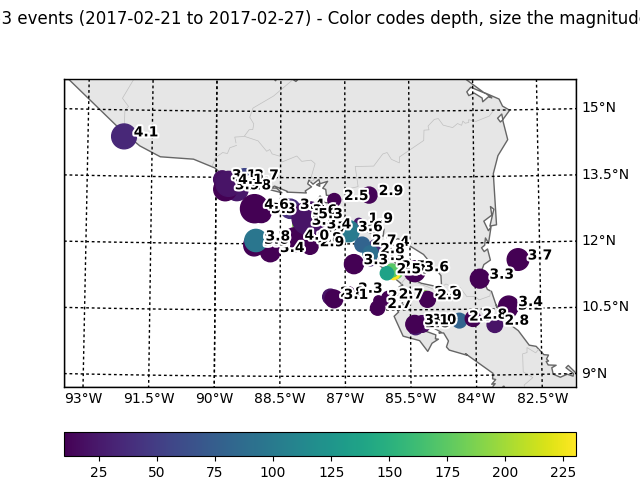

53 Event(s) in Catalog:
2017-02-23T11:27:25.983038Z | +12.480,  -86.682 | 1.894949771 M  | automatic
2017-02-26T09:01:40.024770Z | +10.723,  -86.237 | 1.981136004 M  | manual
...
2017-02-23T19:29:30.944941Z | +12.794,  -89.102 | 4.567481298 M  | automatic
2017-02-24T13:41:13.749506Z | +12.583,  -87.846 | 5.257820586 M  | automatic
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [74]:
eewcat = client_eew.get_events(starttime=start,endtime=end,
                               minlatitude=lat[0],maxlatitude=lat[1],
                               minlongitude=lon[0],maxlongitude=lon[1],
                               orderby='magnitude-asc',
                               includearrivals=True,
                               includeallorigins=True,
                               includeallmagnitudes=True)
fig = eewcat.plot(projection='local')
print(eewcat)

## Misfits 

### How consistent are EEW and main systems ?

In [75]:
missed_main = obspy.core.event.Catalog()
missed_eew = obspy.core.event.Catalog()
falses_eew = obspy.core.event.Catalog()
#falses_main = obspy.core.event.Catalog()
eewcat_checked = obspy.core.event.Catalog()

for e in eewcat.events:
    o = e.preferred_origin() or e.origins[-1]
    found=False 
    real=False
    
    for ref in cat.events: 
        refo = ref.preferred_origin() or ref.origins[-1]
        refm = ref.preferred_magnitude() or ref.magnitudes[-1] 
        if abs(o.time-refo.time) < 60: # These 2 match
            found=True  
            foundo = refo.copy()
            foundm = refm.copy()
            if refo.evaluation_mode != 'automatic' and refm.evaluation_mode != 'automatic' : # the ref eq is real
                real = True 
            if ref.event_type == 'earthquake':     # the ref eq is real
                real = True
            if e.event_type == 'earthquake':       # the eew eq is real
                real = True
    if not found:
        if not real: # misfit & fake
            falses_eew.append(e)
        else:        # misfit but real eq
            missed_main.append(e)
    else:
        if not real: # match & fake
            falses_eew.append(e)
        else:        # match & real eq (eew origins + ref origin)
            eewcat_checked.events.append(e)
            eewcat_checked.events[-1].origins.append(foundo)
            eewcat_checked.events[-1].magnitudes.append(foundm)            

### False alarms
Not identified as earthquakes.

<IPython.core.display.Javascript object>


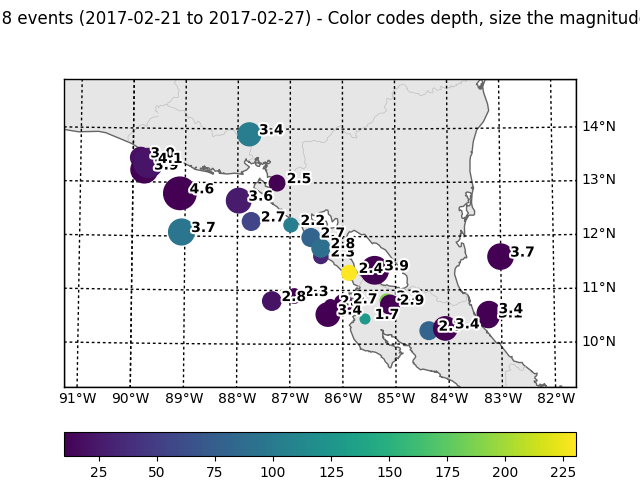

28 Event(s) in Catalog:
2017-02-26T09:01:40.024770Z | +10.723,  -86.237 | 1.981136004 MLv | manual
2017-02-27T04:39:40.025196Z | +10.807,  -85.169 | 2.174464317 MLv | manual
...
2017-02-21T21:14:24.799314Z | +13.353,  -89.711 | 4.139209145 M  | automatic
2017-02-23T19:29:30.944941Z | +12.794,  -89.102 | 4.567481298 M  | automatic
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [76]:
if len(falses_eew)>0:
    falses_eew.plot(projection='local',resolution='i')
print(falses_eew)

###  Review of false alarms

In [83]:
['scolv -E '+str(e.resource_id) for e in falses_eew ] 

['scolv -E smi:ni.gob.ineter/sc-eew-1/2017dzaa',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017eamx',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017drty',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017dznj',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017dzar',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017dzhb',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017dvnb',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017eari',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017dvni',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017dtes',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017dvxz',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017eact',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017dplb',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017dtun',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017dxgz',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017dsdq',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017dtzf',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017dzau',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017eatz',
 'scolv -E smi:ni.gob.ineter/sc-eew-1/2017dzxb',
 'scolv -E smi:ni.go

### Extra EEW missing in EAL

In [77]:
if len(missed_main)>0:
    missed_main.plot(projection='local',resolution='i')
print(missed_main)

0 Event(s) in Catalog:



###  Review of extra EEW

In [78]:
['scolv -E '+str(e.resource_id) for e in missed_main ] 

[]

## How consistent is INETER EEW catalog
### How consistent and how fast are 1rst Mvs ?

<IPython.core.display.Javascript object>


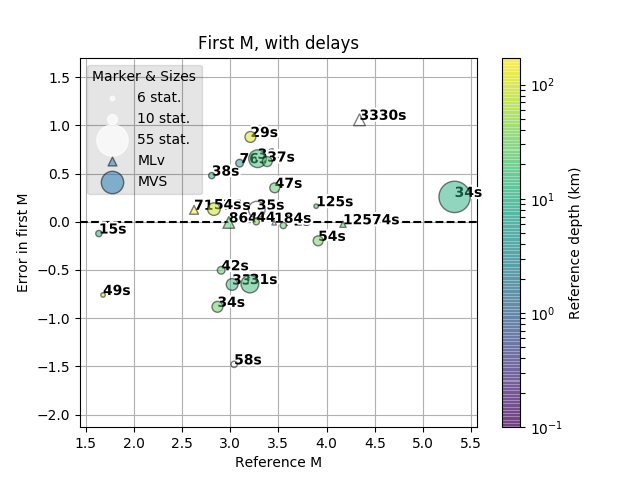

25 Event(s) in Catalog:
2017-02-23T11:27:25.983038Z | +12.480,  -86.682 | 1.894949771 M  | automatic
2017-02-23T06:56:37.211420Z | +11.954,  -86.301 | 2.353789171 M  | automatic
...
2017-02-25T12:44:21.737794Z | +14.393,  -92.165 | 4.195700997 MLv | manual
2017-02-24T13:41:13.749506Z | +12.583,  -87.846 | 5.257820586 M  | automatic
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [79]:
eewcat_checked.plot_Mfirst()

###  Review of erroneous EEM cases

In [80]:
for e in eewcat_checked :
    if abs(e.magnitudes[0].mag-e.magnitudes[-1].mag)>1  :
        print('scolv -E '+str(e.resource_id))

scolv -E smi:ni.gob.ineter/sc-eew-1/2017dsgr
scolv -E smi:ni.gob.ineter/sc-eew-1/2017dtzx


## How performant are the EEW ?

<IPython.core.display.Javascript object>


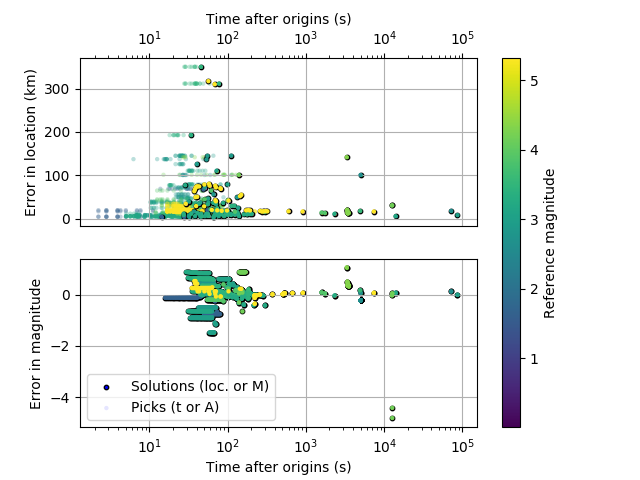

In [81]:
eewcat_checked.plot_eew()

###  Review of slow EEW cases

In [82]:
for e in eewcat_checked :
    if abs(e.magnitudes[0].creation_info.creation_time-e.origins[-1].time)>60:
        print('scolv -E ',str(e.resource_id))

scolv -E  smi:ni.gob.ineter/sc-eew-1/2017dznk
scolv -E  smi:ni.gob.ineter/sc-eew-1/2017duyh
scolv -E  smi:ni.gob.ineter/sc-eew-1/2017dvxw
scolv -E  smi:ni.gob.ineter/sc-eew-1/2017duxq
scolv -E  smi:ni.gob.ineter/sc-eew-1/2017dpgw
scolv -E  smi:ni.gob.ineter/sc-eew-1/2017dqrs
scolv -E  smi:ni.gob.ineter/sc-eew-1/2017dtzx
scolv -E  smi:ni.gob.ineter/sc-eew-1/2017dxlx
